# Exploratory Data Analysis Of The 20 Newsgroups Dataset

The 20 Newsgroups dataset is a corpus of text data downloaded from Usenet groups about 20 years ago. The dataset was thought to have been downloaded by Ken Lang for a paper: 'Newsweeder: Learning to filter netnews' but the original poster of the dataset isn't very clear if that is the case (the original post can be found here: http://qwone.com/~jason/20Newsgroups/). Never the less, the corpus has become a standard in Natural Language Processing (NLP) projects and is even built into popular data science toolkits such as scikit-learn. This notebook is an exploration of the dataset with the intention to use the data to train machine learning models. 

### Import the libraries for data exploration

In [9]:
import pandas as pd
import numpy as np
from scipy import stats 

import os
import re
import glob

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Comment these in if you are running this for the first time 
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('tagsets')

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

from IPython.display import display
from matplotlib import pyplot as plt

get_ipython().run_line_magic("matplotlib", "inline")

### Load the data from the files

The data was downloaded as a zip file from Kaggle and extracted to the subdirectory ```/data/raw```. The zip contained 21 files, one file for each Newsgroup, 20 in total, and one file containing a list of document ID's and their corresponding Newsgroup. It is unclear what that last file is for, as it appears that all the corresponding entries have their Newsgroups labeled. 

The files are opened and the text from them is read and saved to a dictionary to be processed. 

In [10]:
# Importing Newsgroups Manually
cwd = os.getcwd()
files = glob.glob(cwd + "/data/raw/*.txt")

# Dictionary to contain the data
raw_data_dict = {}

print("Newsgroup files:")
# For each newsgroup file
for file in files:
    # Save the catagory to be used as the dict key
    category = file.split("/")[-1].replace(".txt", "")
    print("\t%s" % category)

    # Open the file and save the contents to the dict
    with open(file, "rb") as datafile:
        raw_data_dict[category] = datafile.read().decode("iso-8859-1")

Newsgroup files:
	sci.space
	comp.sys.mac.hardware
	talk.politics.misc
	comp.windows.x
	sci.electronics
	sci.crypt
	comp.graphics
	rec.sport.baseball
	alt.atheism
	sci.med
	soc.religion.christian
	talk.politics.mideast
	misc.forsale
	rec.autos
	rec.sport.hockey
	comp.sys.ibm.pc.hardware
	comp.os.ms-windows.misc
	talk.politics.guns
	rec.motorcycles
	talk.religion.misc


### Isolate each entry in the database and remove duplicates 

The data contained in each file was imported as a single long string so the first thing to do was to split the data into individual entries. Each entry is proceeded with a line containing the Newsgroup that it is from so this was used to separate the entries. Once a list of entries was created it was found that the entries appeared more than once in the dataset. Luckily each entry is given a unique Document_id so these were extracted from the text and used to remove any duplicates from the dataset before they were imported. Once the processing was done, the data was then saved to a pandas dataframe which makes manipulating the data easier.  

In [11]:
# Create a pandas dataframe to contain the data with two columns
data_frame = pd.DataFrame(columns=["entry", "newsgroup"])
info_table = pd.DataFrame(columns=["Missing doc_id", "Total Entries"])

# For each Newsgroup
for key in raw_data_dict.keys():
    # Define the Newsgroup line
    divider = "Newsgroup: " + key
    # print(divider)

    # Split the data using the line as the divider
    # It is assumed that each unique entry has the Newsgroup in its header
    raw_data_dict[key] = raw_data_dict[key].split(divider)

    temp_list = []
    doc_id_list = []
    missing_doc_id = 0

    # Filter out any duplicates based on document_id
    for i in range(len(raw_data_dict[key])):
        # Split the entry into a list
        doc_list = raw_data_dict[key][i].split("\n")

        doc_id = False
        doc_index = []

        # Isolate and save the list element with the document_id
        for j, elem in enumerate(doc_list):
            # Sometimes document_id can use either an upper or lower case d
            if "ocument_id: " in elem:
                doc_index.append(j)
                doc_id = elem.split("ocument_id: ")[1]

        # If the entry has a document_id
        if doc_id:
            # And if the document_id is not a duplicate
            if doc_id not in doc_id_list:
                # Strip the document_id and save the entry to a list
                temp_list.append(raw_data_dict[key][i].split(doc_list[doc_index[0]])[1])
                # Add the document_id to the list of encountered document_ids
                doc_id_list.append(doc_id)

        # Otherwise log that the document_id was missing
        else:
            if len(doc_list) > 1:
                missing_doc_id += 1

    row = pd.Series(
        [len(temp_list), missing_doc_id],
        index=["Total Entries", "Missing doc_id"],
        name=key,
    )
    info_table = info_table.append(row)

    # Append the entry list to the dataframe with its corresponding Newsgroup
    temp_frame = pd.DataFrame(
        list(zip(temp_list, [key] * len(temp_list))), columns=["entry", "newsgroup"]
    )
    data_frame = data_frame.append(temp_frame)

print("Summary:")
display(info_table)
print("\nResulting Dataframe:")
display(data_frame.describe())

Summary:


,Missing doc_id,Total Entries
sci.space,0,987
comp.sys.mac.hardware,0,961
talk.politics.misc,0,775
comp.windows.x,0,980
sci.electronics,4,981
sci.crypt,0,991
comp.graphics,1,973
rec.sport.baseball,0,994
alt.atheism,1,799
sci.med,0,990



Resulting Dataframe:


,entry,newsgroup
count,18828,18828
unique,18828,20
top,\nFrom: reilly@admail.fnal.gov (Rob Reilly)\nS...,rec.sport.hockey
freq,1,999


While importing the data it was noticed that there were some entries that were missing Document ID's. The first table above shows that there were only a handful missing so these entries were ignored. It appears that the original uploader of the data to Kaggle did the same as they list that there are 18828 entries in the dataset which matches the data imported here. The first table also shows the number of entries in each Newsgroup as about the same which means it is possible to directly compare Newsgroups without having to apply more complex statistics. 

### Sample Entry

In [12]:
data_frame = data_frame.reset_index()
print(data_frame["entry"].iloc[0])


From: et@teal.csn.org (Eric H. Taylor)
Subject: Re: Gravity waves, was: Predicting gravity wave quantization & Cosmic Noise

In article <C4KvJF.4qo@well.sf.ca.us> metares@well.sf.ca.us (Tom Van Flandern) writes:
>crb7q@kelvin.seas.Virginia.EDU (Cameron Randale Bass) writes:
>> Bruce.Scott@launchpad.unc.edu (Bruce Scott) writes:
>>> "Existence" is undefined unless it is synonymous with "observable" in
>>> physics.
>> [crb] Dong ....  Dong ....  Dong ....  Do I hear the death-knell of
>> string theory?
>
>     I agree.  You can add "dark matter" and quarks and a lot of other
>unobservable, purely theoretical constructs in physics to that list,
>including the omni-present "black holes."
>
>     Will Bruce argue that their existence can be inferred from theory
>alone?  Then what about my original criticism, when I said "Curvature
>can only exist relative to something non-curved"?  Bruce replied:
>"'Existence' is undefined unless it is synonymous with 'observable' in
>physics.  We cannot o

This is an example of a typical entry in the database. Most entries contain a header, footer, and some of them contain a quote block where the user is replying to someone. The header is usually who submitted the post and the subject of that post, this data is structured. The footer is something that the user signs off each post with and can be very unstructured. As you see above, the user signs off their posts with a quote about Tesla separated by two dashed lines. The quote block usually contains '>' symbols but can vary from post to post. 

# Text Analysis

### Character Count Distribution

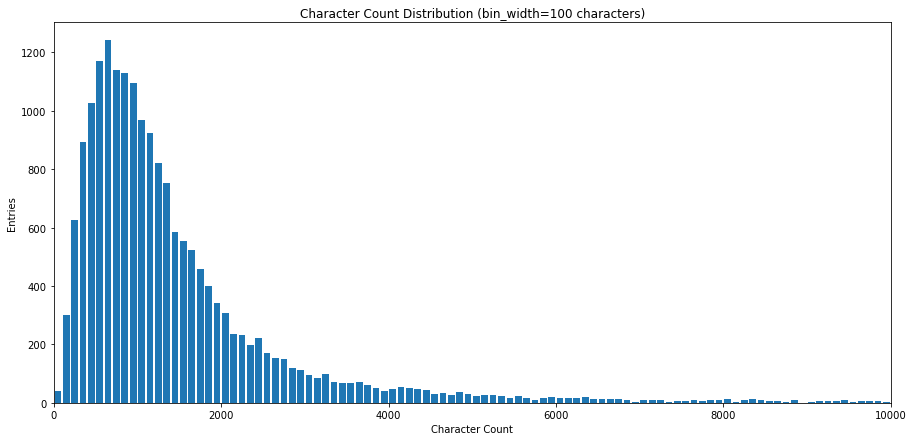

Longest Entry: 160548
Longest Entries Newsgroup: comp.os.ms-windows.misc
Peak Length Bin: 600
Mean length: 1803
Median length: 1075
Mode length: 664


In [13]:
# ----------Character Count Histogram----------

# Set the figure size and bin width
plt.rcParams["figure.figsize"] = [15, 7]
bin_width = 100

# Extract the string lengths and create the bins for the histogram
newsgroup_len = data_frame["entry"].str.len()
bins = range(0, max(newsgroup_len) + bin_width, bin_width)

# Plot the histogram
y, x, _ = plt.hist(newsgroup_len, bins=bins, rwidth=0.8)

# Set the histogram properties and show
plt.xlim(0, 10000)
plt.title("Character Count Distribution (bin_width=100 characters)")
plt.xlabel("Character Count")
plt.ylabel("Entries")
plt.show()

# Print some details about the entries
print("Longest Entry:", max(newsgroup_len))
longest_entry = data_frame.iloc[newsgroup_len.sort_values(ascending=False).index[0]]
print("Longest Entries Newsgroup:", longest_entry["newsgroup"])
print("Peak Length Bin:", int(x[y.argmax()]))
print("Mean length:", int(np.mean(newsgroup_len)))
print("Median length:", int(np.median(newsgroup_len)))
print("Mode length:", stats.mode(newsgroup_len)[0][0])

As you can see the distribution follows a positive skew (skewed right). This makes sense as it is easier to write a shorter post than a long one. Only a slice of the histogram is shown, as the maximum value in the dataset is over 250 times the peak value.  

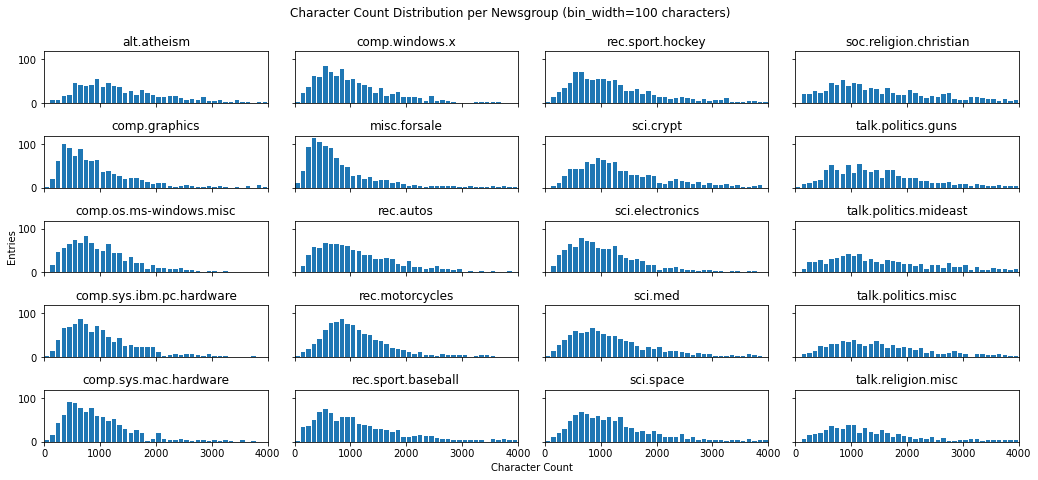

In [14]:
# ----------Character Count Histogram for each Newsgroup----------

# Setup the subplots to plot a histogram for each newsgroup
fig, axs = plt.subplots(5, 4, sharey=True, sharex=True, tight_layout=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Character Count")
plt.ylabel("Entries")
fig.suptitle("Character Count Distribution per Newsgroup (bin_width=100 characters)")

j = -1
k = -5

# For each newsgroup
for i, newsgroup in enumerate(sorted(set(data_frame["newsgroup"]))):
    # Extract the string lengths and create the bins for the histogram
    newsgroup_len = (
        data_frame.groupby(["newsgroup"]).get_group(newsgroup)["entry"].str.len()
    )
    bins = range(0, max(newsgroup_len) + bin_width, bin_width)

    # Used to correctly define the subplots
    if i % 5 == 0:
        j += 1
        k += 5

    # Plot the subplot for the newsgroup
    axs[int(i - k)][j].set_title(newsgroup)
    axs[int(i - k)][j].hist(newsgroup_len, bins=bins, rwidth=0.8)
    axs[int(i - k)][j].set_xlim(0, 4000)

plt.show()

Looking at the breakdown of character length for each Newsgroup it is clear there is a distinction between the Newsgroups. The Newsgroup with the shortest entries appears to be ```misc.forsale``` which makes sense as ads are typically not that long. Groups where you would expect to see more longform discussion such as the politics and religion Newsgroups have more of a spread out distribution which indicates that this is the case.  

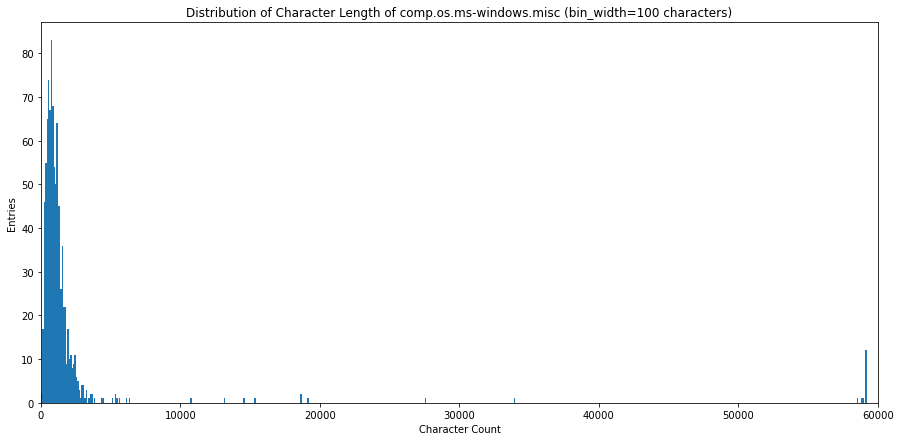

In [15]:
# ----------Character Count Histogram of comp.os.ms-windows.misc----------

# Extract the string lengths and create the bins for the histogram
newsgroup_len = (
    data_frame.groupby(["newsgroup"])
    .get_group("comp.os.ms-windows.misc")["entry"]
    .str.len()
)
bins = range(0, max(newsgroup_len) + bin_width, bin_width)

# Plot the histogram
plt.hist(newsgroup_len, bins=bins)

# Set the histogram properties and show
plt.xlim(0, 60000)
plt.title(
    "Distribution of Character Length of comp.os.ms-windows.misc (bin_width=100 characters)"
)
plt.xlabel("Character Count")
plt.ylabel("Entries")
plt.show()

While exploring the Newsgroups an unusual artifact was found in the ```comp.os.ms-windows.misc``` group. There is a cluster of posts with about 60000 characters in them. ```comp.os.ms-windows.misc``` is also the Newsgroup with the longest post containing 160548 characters. There appears to be unusual activity in this newsgroup as some posts are particularly long.  

In [16]:
# Since scrolling output is not supported on Github this has been commented out
# to save you having to scroll through it all

# For each entry in the comp.os.ms-windows.misc newsgroup
# for entry in data_frame.groupby(["newsgroup"]).get_group("comp.os.ms-windows.misc")[
#     "entry"
# ]:
#     # If the entry is bigger than 55000 characters print it
#     if len(entry) > 55000:
#         print(entry)

If you comment in the print statement above and have a look at the longest posts in ```comp.os.ms-windows.misc``` it appears that they are full of nonsense characters (to save you having to scroll through extremely long posts they have been omitted from the Github version). After reading some of the posts it was found that people were sharing wallpapers and images using text! They were deconstructing and sharing images directly on the message boards as strings of text with the idea that users would reconstruct the images on their own computers. One poster shared an image across 14 posts each containing approx 60000 characters which explains the bump in the histogram. 

### Word Count Distribution 

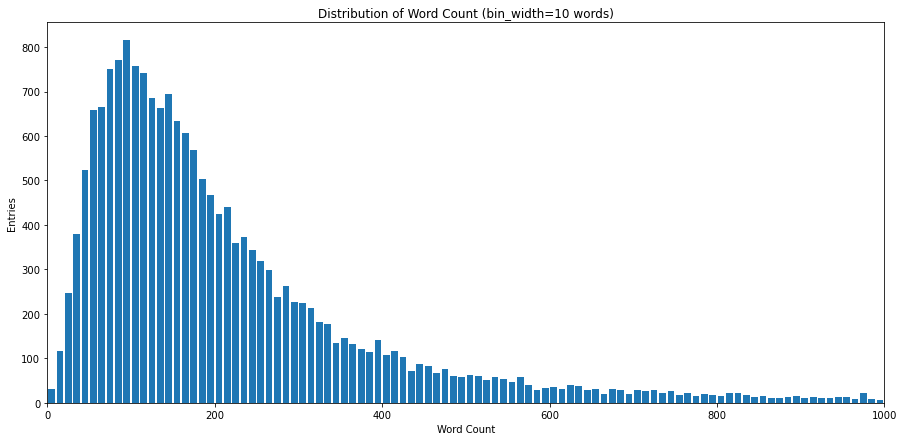

Longest Entry: 11795
Longest Entry Newsgroup: sci.electronics
Peak Length Bin: 90
Mean length: 272
Median length: 164
Mode length: 94


In [17]:
# Function to create a list from a long string of text
def word_list(text):
    return text.split()


# ----------Word Count Histogram----------

# Set the figure size and bin width
plt.rcParams["figure.figsize"] = [15, 7]
bin_width = 10

# Extract the word list lengths and create the bins for the histogram
newsgroup_len = data_frame["entry"].apply(word_list).str.len()
bins = range(0, max(newsgroup_len) + bin_width, bin_width)

# Plot the histogram
y, x, _ = plt.hist(newsgroup_len, bins=bins, rwidth=0.8)

# Set the histogram properties and show
plt.xlim(0, 1000)
plt.title("Distribution of Word Count (bin_width=10 words)")
plt.xlabel("Word Count")
plt.ylabel("Entries")
plt.show()

# Print some details about the entries
print("Longest Entry:", max(newsgroup_len))
longest_entry = data_frame.iloc[newsgroup_len.sort_values(ascending=False).index[0]]
print("Longest Entry Newsgroup:", longest_entry["newsgroup"])
print("Peak Length Bin:", int(x[y.argmax()]))
print("Mean length:", int(np.mean(newsgroup_len)))
print("Median length:", int(np.median(newsgroup_len)))
print("Mode length:", stats.mode(newsgroup_len)[0][0])

As you can see the distribution of words looks very similar to the distribution of characters in the dataset. Similarly a slice of the histogram is shown as the post with the maximum word count is over 100 times that of the peak word count. 

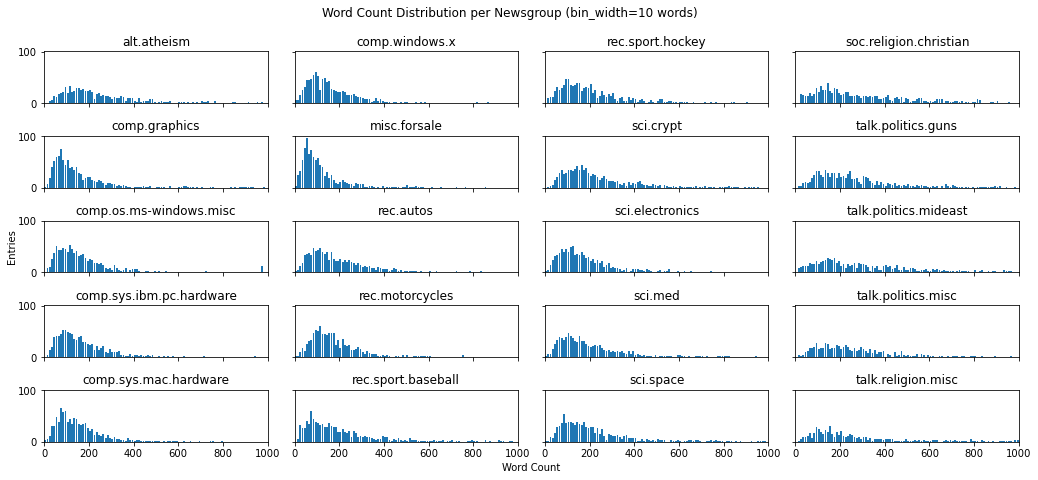

In [18]:
# ----------Word Count Histogram for each Newsgroup----------

# Setup the subplots to plot a histogram for each newsgroup
fig, axs = plt.subplots(5, 4, sharey=True, sharex=True, tight_layout=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Word Count")
plt.ylabel("Entries")
fig.suptitle("Word Count Distribution per Newsgroup (bin_width=10 words)")

j = -1
k = -5

# For each newsgroup
for i, newsgroup in enumerate(sorted(set(data_frame["newsgroup"]))):
    # Extract the word list lengths and create the bins for the histogram
    newsgroup_len = (
        data_frame.groupby(["newsgroup"])
        .get_group(newsgroup)["entry"]
        .apply(word_list)
        .str.len()
    )
    bins = range(0, max(newsgroup_len) + bin_width, bin_width)

    # Used to correctly define the subplots
    if i % 5 == 0:
        j += 1
        k += 5

    # Plot the subplot for the newsgroup
    axs[int(i - k)][j].set_title(newsgroup)
    axs[int(i - k)][j].hist(newsgroup_len, bins=bins, rwidth=0.8)
    axs[int(i - k)][j].set_xlim(0, 1000)

plt.show()

The breakdown of word count for each Newsgroup follows a similar story as above where the ```misc.forsale``` group has the most right skewed histogram. The reason for this is that ads don't tend to be that long and the more discussion heavy groups have more spread out histograms.  

In [19]:
# Same here, the output is too long for the Github so it has been commented out

# For each entry in the rec.sport.hockey newsgroup
# for entry in (
#     data_frame.groupby(["newsgroup"])
#     .get_group("sci.electronics")["entry"]
#     .apply(word_list)
# ):
#     # If the entry is bigger than 10000 characters print it
#     if len(entry) > 10000:
#         print(" ".join(entry))

If you comment in the print statement above you will see that the longest post comes from ```sci.electronics```. It appears to be an FAQ which if written in 12 point Ariel font would be a 26 page document! 

### Word Frequency Ditribution and Zipf's Law 

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
word,the,to,of,and,in,is,that,ax,it,for,you,from,on,this,be,not,have,are,edu,with
count,238656,120347,107268,95047,80633,70024,65016,62416,54961,45837,44414,37172,33385,32541,30804,30102,29912,29815,29227,28545


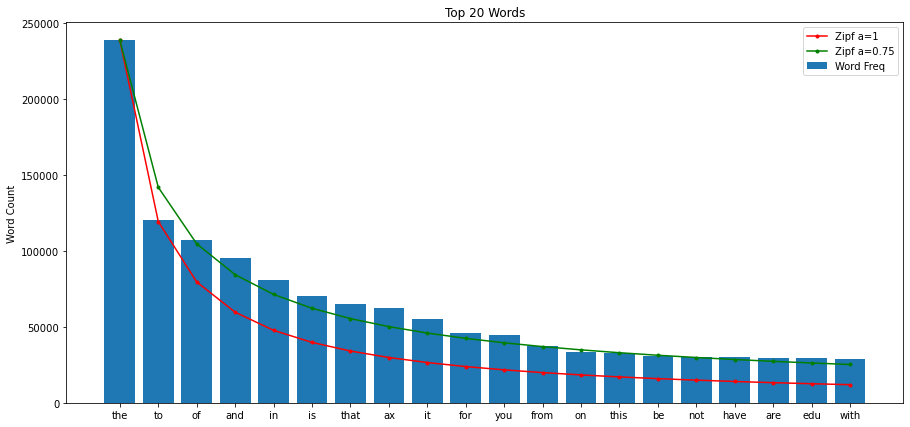

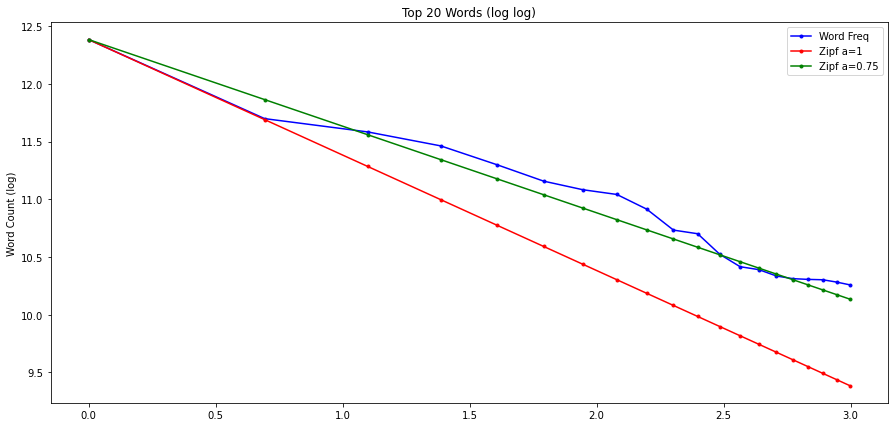

In [20]:
# ----------Word Frequency Bar Chart----------

# Function to find the top n number of words in a corpus of text
def top_words(corpus, n=0):

    # Vectorize the corpus and create a bag of words
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    # Create a list of words sorted by the word frequency
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Return n number of words from the list
    return words_freq[:n]


# Save the word frequency to a dataframe and display
common_words = top_words(data_frame["entry"], 20)
common_words_df = pd.DataFrame(common_words, columns=["word", "count"])
common_words_df.index = common_words_df.index + 1
display(common_words_df.T)

# Function to calculate the Zipfian values
def zipf(r, a):
    return 1 / ((r) ** a)


# Zipfian values for a=1
zipf_val1 = pd.Series([zipf(x, a=1) for x in common_words_df.index])
zipf_val1 = zipf_val1 * max(common_words_df["count"])

# Zipfian values for a=0.75
zipf_val2 = pd.Series([zipf(x, a=0.75) for x in common_words_df.index])
zipf_val2 = zipf_val2 * max(common_words_df["count"])

# Plot a bar chart of the most frequent words
plt.title("Top 20 Words")
plt.ylabel("Word Count")
plt.bar(common_words_df["word"], common_words_df["count"], label="Word Freq")
plt.plot(common_words_df["word"], zipf_val1, color="red", marker=".", label="Zipf a=1")
plt.plot(
    common_words_df["word"], zipf_val2, color="green", marker=".", label="Zipf a=0.75"
)
plt.legend()
plt.show()

# Plot a log log plot of the most frequent words
plt.title("Top 20 Words (log log)")
plt.ylabel("Word Rank (log)")
plt.ylabel("Word Count (log)")
plt.plot(
    np.log(common_words_df.index),
    np.log(common_words_df["count"]),
    color="blue",
    marker=".",
    label="Word Freq",
)
plt.plot(
    np.log(common_words_df.index),
    np.log(zipf_val1),
    color="red",
    marker=".",
    label="Zipf a=1",
)
plt.plot(
    np.log(common_words_df.index),
    np.log(zipf_val2),
    color="green",
    marker=".",
    label="Zipf a=0.75",
)
plt.legend()
plt.show()

Unsurprisingly, the most common words in the corpus are the most common words in english, the, to, of, and, in, etc.. What is surprising is that the corpus does not exactly follow a Zipfian distribution. Zipf’s Law is an empirical law that says that the frequency of each word in a language is close to inversely proportional to its rank in the frequency table. In other words:

<center>$f(r) \propto \frac{1}{r^\alpha}$</center>

where r is the frequency rank of a word, f(r) is its frequency in the corpus, and $\alpha \approx 1$. After some testing it was found that the distribution of words closer follows a Zipfian distribution where $\alpha \approx 0.75$, this could still be said to be a Zipfian distribution but it might also indicate that the corpus is not large enough to exactly follow Zipfs Law. 

### Word Frequency Ditribution minus Stop Words

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
word,ax,edu,subject,com,one,use,write,would,articl,like,get,know,peopl,think,time,say,go,also,make,work
count,62551,29228,20655,17770,15386,15133,14920,14805,11887,10843,10556,9573,9553,8461,8352,7834,7373,7236,7221,6565


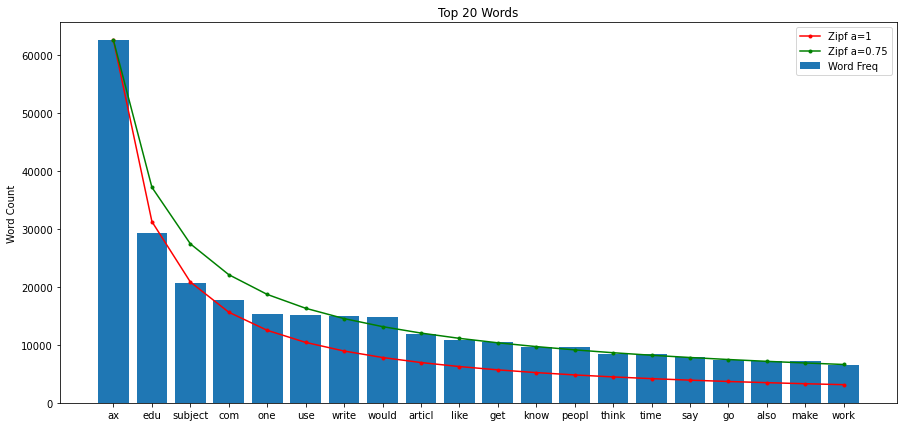

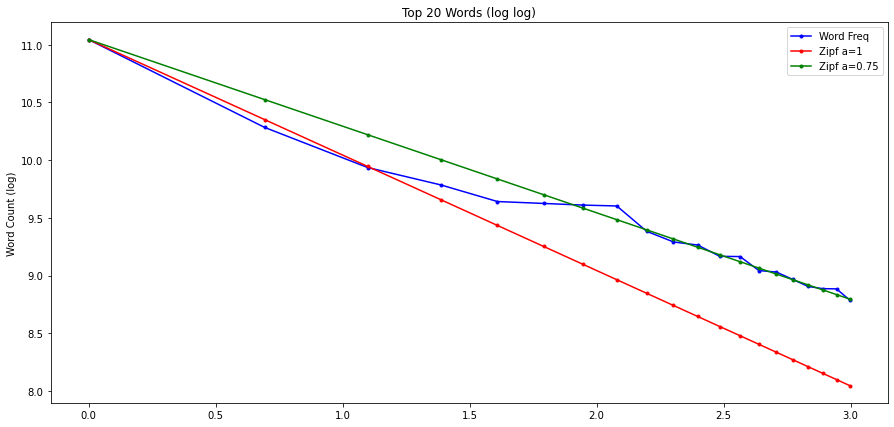

In [21]:
# ----------Word Frequency Bar Chart Minus Stop Words----------

# Function to remove stop words and clean a given string
def strip_stopwords(text):
    # Remove punctuation, set all words to lower case and create a list of the words
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()

    # Initilize the portstemmer and create a list of stop words
    ps = PorterStemmer()
    all_stopwords = stopwords.words("english")

    # Stem all the words in the list and remove any stop words
    text = [ps.stem(word) for word in text if not word in set(all_stopwords)]

    # Recreate the string and return
    return " ".join(text)


# Remove the stop words, punctuation and set all words to lower case
data_frame["entry-s"] = data_frame["entry"].apply(strip_stopwords)

# Save the word frequency to a dataframe and display
common_words = top_words(data_frame["entry-s"], 20)
common_words_df = pd.DataFrame(common_words, columns=["word", "count"])
common_words_df.index = common_words_df.index + 1
display(common_words_df.T)

# Zipfian values for a=1
zipf_val1 = pd.Series([zipf(x, a=1) for x in common_words_df.index])
zipf_val1 = zipf_val1 * max(common_words_df["count"])

# Zipfian values for a=0.75
zipf_val2 = pd.Series([zipf(x, a=0.75) for x in common_words_df.index])
zipf_val2 = zipf_val2 * max(common_words_df["count"])

# Plot a bar chart of the most frequent words
plt.title("Top 20 Words")
plt.ylabel("Word Count")
plt.bar(common_words_df["word"], common_words_df["count"], label="Word Freq")
plt.plot(common_words_df["word"], zipf_val1, color="red", marker=".", label="Zipf a=1")
plt.plot(
    common_words_df["word"], zipf_val2, color="green", marker=".", label="Zipf a=0.75"
)
plt.legend()
plt.show()

# Plot a log log plot of the most frequent words
plt.title("Top 20 Words (log log)")
plt.ylabel("Word Rank (log)")
plt.ylabel("Word Count (log)")
plt.plot(
    np.log(common_words_df.index),
    np.log(common_words_df["count"]),
    color="blue",
    marker=".",
    label="Word Freq",
)
plt.plot(
    np.log(common_words_df.index),
    np.log(zipf_val1),
    color="red",
    marker=".",
    label="Zipf a=1",
)
plt.plot(
    np.log(common_words_df.index),
    np.log(zipf_val2),
    color="green",
    marker=".",
    label="Zipf a=0.75",
)
plt.legend()
plt.show()

After removing the stop words from the corpus some interesting trends appear, 'ax' is the most frequent word followed by 'edu', 'subject', 'com', and 'one'. 'edu', 'subject' and 'com' are easy to explain, .edu and .com are top level domains and are used frequently in email addresses. 'subject' also appears at least once in each entries header so it's frequency should about match the number of entries in the dataset.  

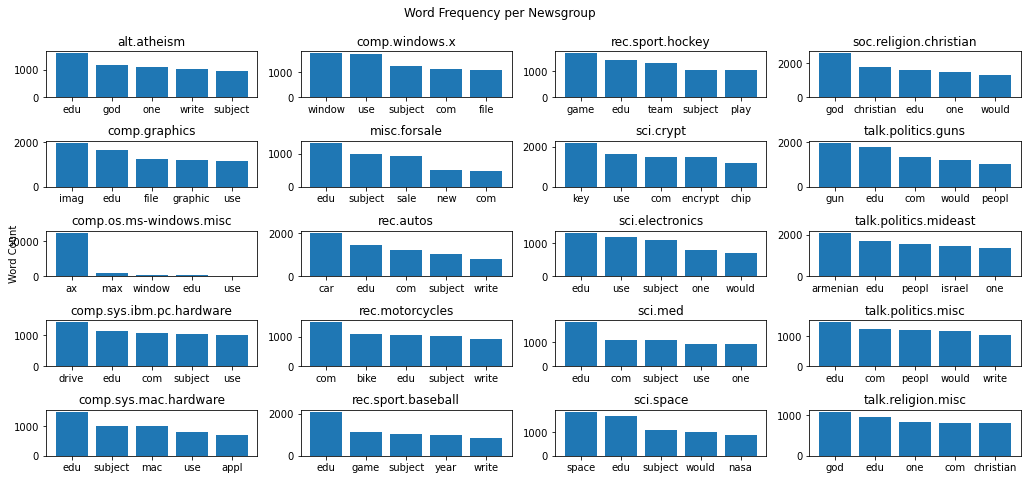

In [22]:
# ----------Word Frequency Bar Chart Minus Stop Words for each Newsgroup----------

# Setup the subplots to plot a bar chart for each newsgroup
fig, axs = plt.subplots(5, 4, tight_layout=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("Word Count")
fig.suptitle("Word Frequency per Newsgroup")

j = -1
k = -5

# For each newsgroup
for i, newsgroup in enumerate(sorted(set(data_frame["newsgroup"]))):
    # Find the top 5 words for the newsgroup and their count
    common_words = top_words(
        data_frame.groupby(["newsgroup"]).get_group(newsgroup)["entry-s"], 5
    )
    common_words_df = pd.DataFrame(common_words, columns=["word", "count"])

    # Used to correctly define the subplots
    if i % 5 == 0:
        j += 1
        k += 5

    # Plot the subplot for the newsgroup
    axs[int(i - k)][j].set_title(newsgroup)
    axs[int(i - k)][j].bar(common_words_df["word"], common_words_df["count"])


plt.show()

Note how the y axis isn't the same for all plots, there are over 50000 mentions of 'ax' in the ```comp.os.ms-windows.misc``` Newsgroup and 'ax' does not feature in the top 5 of any other Newsgroup. After inspecting the data it appears that the letters 'AX' occur frequently in the nonsense characters of the images that were shared as text as mentioned before. When removing the stop words and vectorizing the dataset these instances of 'AX' are picked up as words and dominate the word counts. 

### Word Cloud

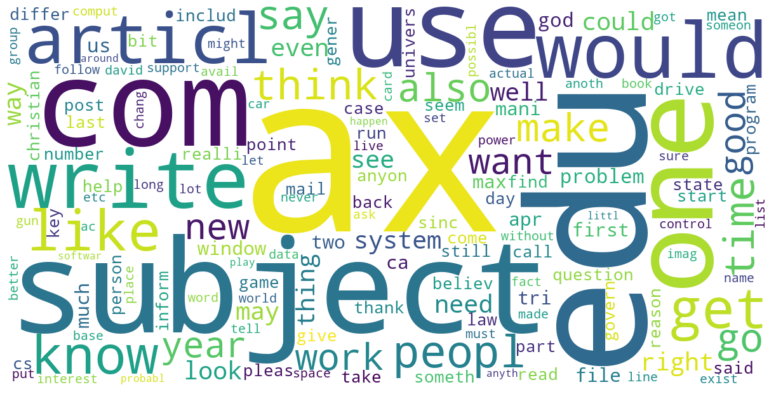

In [23]:
# ----------Word Cloud----------

# Create a dict of the top 150 words in the dataset
common_words = top_words(data_frame["entry-s"], 150)
common_words_dict = dict(common_words)

# Generate the word cloud and plot
wc = WordCloud(
    width=1200, height=600, background_color="white"
).generate_from_frequencies(common_words_dict)

plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

This is a simple word cloud featuring the top 150 words in the dataset.

### Part of Speech (POS) Distribution 

In [24]:
# Function to return a string as a list of pos tags
def pos_tagger(text):
    # Tokenize the text and calcualte the pos
    text = nltk.word_tokenize(text)
    tagged_text = nltk.pos_tag(text)
    # Return the list of the pos
    return list(dict(tagged_text).values())


data_frame["pos"] = data_frame["entry"].apply(pos_tagger)

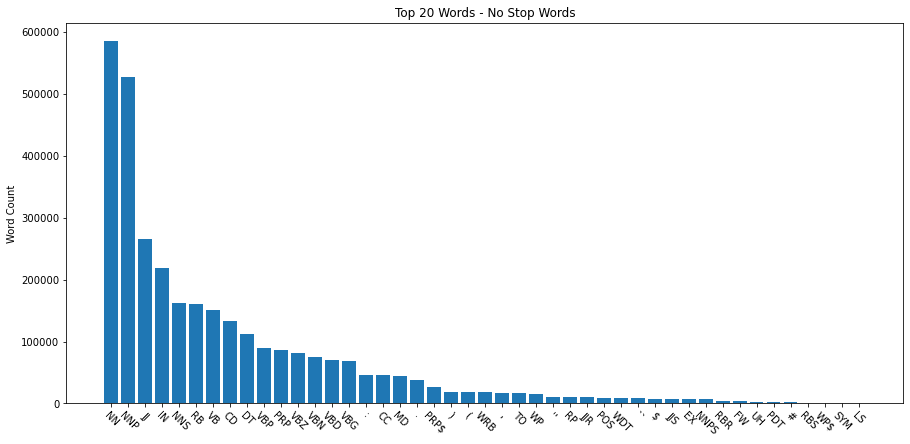

In [25]:
# ----------POS Bar Chart----------

# Caculate the frequency of pos tags and plot
df_pos = data_frame["pos"].explode().value_counts()

plt.title("Top 20 Words - No Stop Words")
plt.ylabel("Word Count")
plt.bar(df_pos.index, df_pos.values)
plt.xticks(rotation=-45)
plt.show()

# Comment me in to see what the abbreviations for the types of words are
# for item in df_pos.index:
#     print(nltk.help.upenn_tagset(item))

The description of all the abbreviations can be printed by uncommenting the for loop above but the top 5 word types are as follows:

    NN: noun, common, singular or mass
        eg. common-carrier cabbage knuckle-duster Casino afghan shed thermostat

    NNP: noun, proper, singular
        eg. Motown Venneboerger Czestochwa Ranzer Conchita Trumplane Christos

    JJ: adjective or numeral, ordinal
        eg. third ill-mannered pre-war regrettable oiled calamitous first separable

    IN: preposition or conjunction, subordinating
        eg. astride among uppon whether out inside pro despite on by throughout

    NNS: noun, common, plural
        eg. undergraduates scotches bric-a-brac products bodyguards facets coasts

### Number of emails 

In [26]:
# Find all the emails in each entry
data_frame["email"] = data_frame["entry"].str.findall(r"\S+@\S+\.\S+")

In [27]:
# Create the set of all the emails to calculate the number of unique emails
email_list = [item for sublist in list(data_frame["email"]) for item in sublist]
email_set = set(email_list)

print("Number of unique emails:", len(email_set))
df = pd.DataFrame(email_list).value_counts()[:10]
df.index.name = "Top emails by occurance:"
df.name = "Number"
df = pd.DataFrame(df)
display(df)

Number of unique emails: 26492


,Number
0,
henry@zoo.toronto.edu,184
livesey@solntze.wpd.sgi.com,148
cramer@optilink.COM,142
sera@zuma.UUCP,131
sandvik@newton.apple.com,122
strnlght@netcom.com,118
jake@bony1.bony.com,116
cdt@sw.stratus.com,111
maynard@ramsey.cs.laurentian.ca,108


These are the emails that most often appear in the dataset as either the user who made a post or a user who was mentioned in the body of a post.  

In [28]:
# Function to isolate who made a given post
def from_finder(text):
    # Split the entry into a list
    text_list = text.split("\n")
    from_list = []

    # For each item in the list
    for item in text_list:
        # If From: is in the item
        if "From:" in item:
            # Append it to a list
            from_list.append(item.strip("From: "))

    # It is assumed that the first instance of From: will be the poster so only return the first instance
    return from_list[0]


# Isolate who posted each entry
data_frame["from"] = data_frame["entry"].apply(from_finder)

# Calculate the most prolific posters overall
print("Most prolific posters:")
df = data_frame["from"].value_counts()[:10]
df.index.name = "Most prolific posters:"
df.name = "Number"
df = pd.DataFrame(df)
display(df)

# Calculate the most prolific posters in each Newsgroup
for newsgroup in sorted(set(data_frame["newsgroup"])):
    df = (
        data_frame.groupby(["newsgroup"])
        .get_group(newsgroup)["from"]
        .value_counts()[:5]
    )
    df.index.name = "Most prolific posters in %s:" % newsgroup
    df.name = "Number"
    df = pd.DataFrame(df)
    # To save you having to scroll throuhg long posts of users the per Newsgroup breakdown has been omitted
    # display(df)

Most prolific posters:


,Number
Most prolific posters:,
sera@zuma.UUCP (Serdar Argic),121
geb@cs.pitt.edu (Gordon Banks),74
henry@zoo.toronto.edu (Henry Spencer),68
sandvik@newton.apple.com (Kent Sandvik),67
livesey@solntze.wpd.sgi.com (Jon Livesey),65
cdt@sw.stratus.com (C. D. Tavares),65
keith@cco.caltech.edu (Keith Allan Schneider),57
golchowy@alchemy.chem.utoronto.ca (Gerald Olchowy),52
cramer@optilink.COM (Clayton Cramer),50


This is a breakdown of the top posters in each Newsgroup. The most prolific poster was ```sera@zuma.UUCP (Serdar Argic)``` who posted over 120 times to the ```talk.politics.mideast``` Newsgroup accounting for 12% of the Newsgroups corpus!  

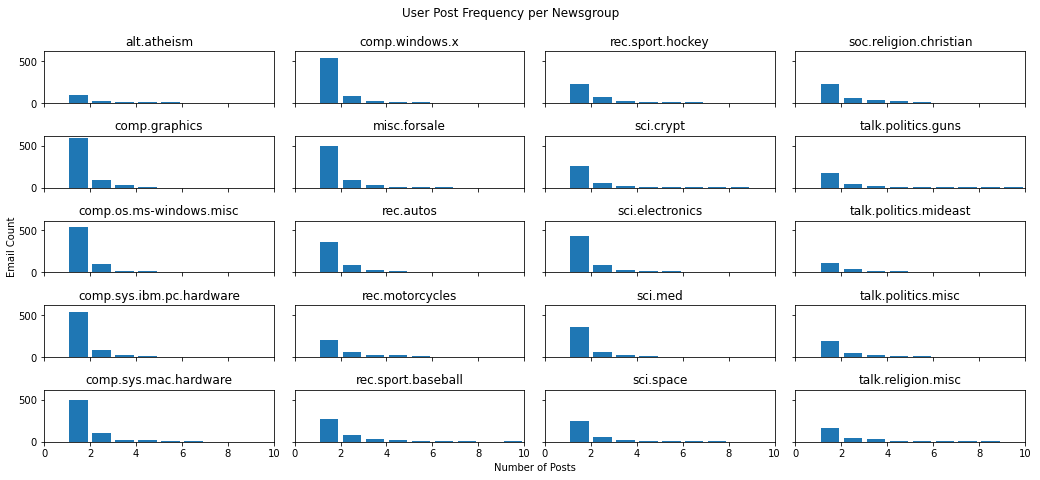

In [29]:
bin_width = 1

# Setup the subplots to plot a histogram for each newsgroup
fig, axs = plt.subplots(5, 4, sharex=True, sharey=True, tight_layout=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Number of Posts")
plt.ylabel("Email Count")
fig.suptitle("User Post Frequency per Newsgroup")

j = -1
k = -5

# For each newsgroup
for i, newsgroup in enumerate(sorted(set(data_frame["newsgroup"]))):
    # Extract the Number of times each user posted
    newsgroup_len = (
        data_frame.groupby(["newsgroup"]).get_group(newsgroup)["from"].value_counts()
    )
    bins = range(0, max(newsgroup_len) + bin_width, bin_width)

    # Used to correctly define the subplots
    if i % 5 == 0:
        j += 1
        k += 5

    # Plot the subplot for the newsgroup
    axs[int(i - k)][j].set_title(newsgroup)
    axs[int(i - k)][j].hist(newsgroup_len, bins=bins, rwidth=0.8)
    axs[int(i - k)][j].set_xlim(0, 10)

plt.show()

The above is a histogram of the number of times users post to each Newsgroup clearly showing that the majority of people only post once with the number of more frequent posters tailing off sharply.

### Conclusions

As you can see, the 20 Newsgroup dataset is simple but fully featured and is a good sample dataset to be used on machine learning classification models. Perhaps the dataset could be considered small as it does not follow a Zipfian distribution exactly but should be large enough to test out simple models. In the Jupyter notebook ```20_Newsgroups_Machine_Learning.ipynb``` the dataset is used to train two deep learning models, an Artificial Neural Network and a Convolutional Neural Network. A Multinomial Naive Bayes model is also tested and used as a baseline to compare with. 

### References:

- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4176592/
- https://getnave.com/blog/histogram-diagram/
- https://www.datacamp.com/community/tutorials/wordcloud-python
- https://amueller.github.io/word_cloud/index.html
- https://plus.maths.org/content/mystery-zipf
- https://en.wikipedia.org/wiki/Zipf%27s_law
- https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-3-zipfs-law-data-visualisation-fc9eadda71e7
- https://www.youtube.com/watch?v=fCn8zs912OE
- https://stackoverflow.com/questions/16288497/find-the-most-common-term-in-scikit-learn-classifier
- https://matplotlib.org/stable/index.html
- https://www.tutorialspoint.com/python_text_processing/python_tagging_words.htm
- https://www.nltk.org/book/ch05.html
- https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/
- https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
